In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import lsqlin
from scipy import stats
import copy 
from sklearn import svm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import metrics 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from sklearn.model_selection import KFold

pd.set_option('max_columns', None)

In [2]:
vix_df = pd.read_excel('VIXfutures_20080414_20201231.xlsx')

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5

In [5]:
#######################################################
####
#### 1-month and 5-month rolling futures portfolios
####
#######################################################

dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )

r_trade = np.zeros((T-1,5))
r_trade[:,0] = np.ones(T-1)*r*dt
r_trade[:,1] = -np.diff(vxx)/vxx[:-1] + 2*np.diff(vxz)/vxz[:-1]
r_trade[:,2] = -np.diff(vxx)/vxx[:-1] + np.diff(vxz)/vxz[:-1]+r*dt
r_trade[:,3] = np.diff(vxx)/vxx[:-1] - 2*np.diff(vxz)/vxz[:-1]
r_trade[:,4] = np.diff(vxx)/vxx[:-1] - np.diff(vxz)/vxz[:-1]+r*dt

ind_trade = np.zeros((T-1,5)) ### index of max return, to be predicted by classifier
for t in range(T-1):
    ind = np.argmax(r_trade[t,:])
    ind_trade[t,ind] = 1
# y = np.argmax(r_trade,axis=1) # 這樣最快


In [6]:
'''
Build lookback window dataset
'''
def create_dataset(dataset_X,dataset_y,look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset_X)-look_back):
        a = dataset_X[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset_y[i + look_back,:])
    return np.array(dataX), np.array(dataY)



K-Folds Cross Validation:  1
Total Data Size:  3201
Training Fold Size:  2560
Training Dates:  2010-10-29 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2008-04-16 00:00:00  to  2010-10-28 00:00:00
Testing Fold Size:  641


Epoch 64: early stopping
Cumulative Return (percentage annualized) : 228.4139
Sharpe ratio (percentage) : 5.2263


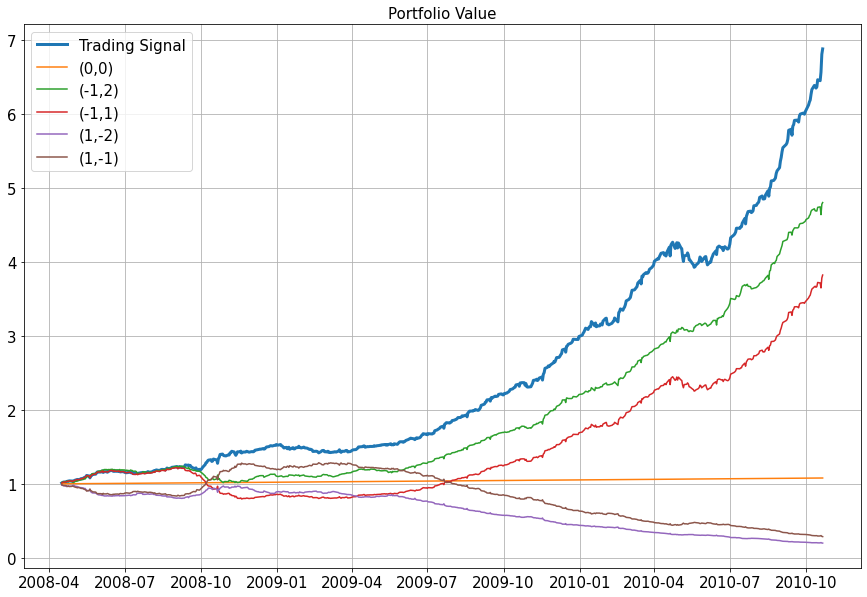



K-Folds Cross Validation:  2
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2010-10-29 00:00:00  to  2013-05-16 00:00:00
Testing Fold Size:  640


Epoch 75: early stopping
Cumulative Return (percentage annualized) : 202.3720
Sharpe ratio (percentage) : 3.9777


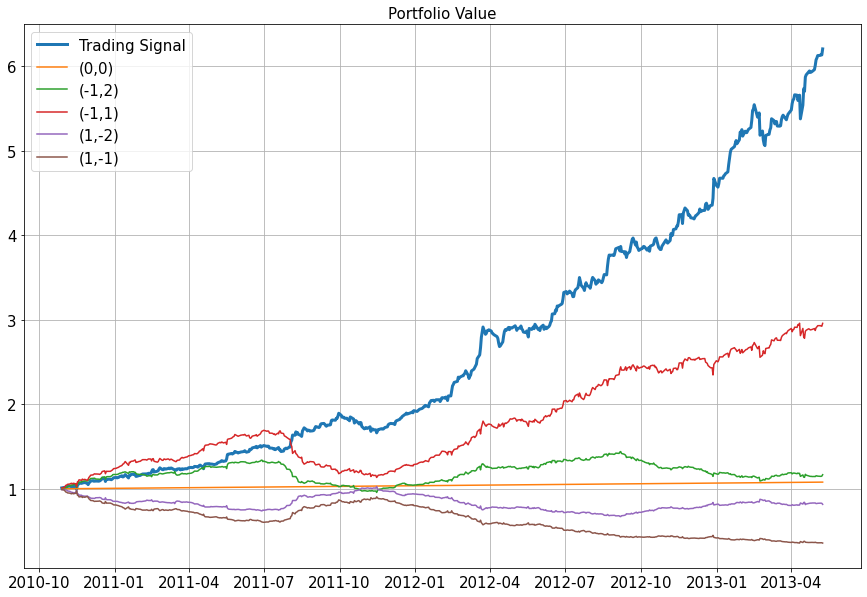



K-Folds Cross Validation:  3
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2013-05-17 00:00:00  to  2015-11-30 00:00:00
Testing Fold Size:  640


Epoch 65: early stopping
Cumulative Return (percentage annualized) : 223.0610
Sharpe ratio (percentage) : 5.2289


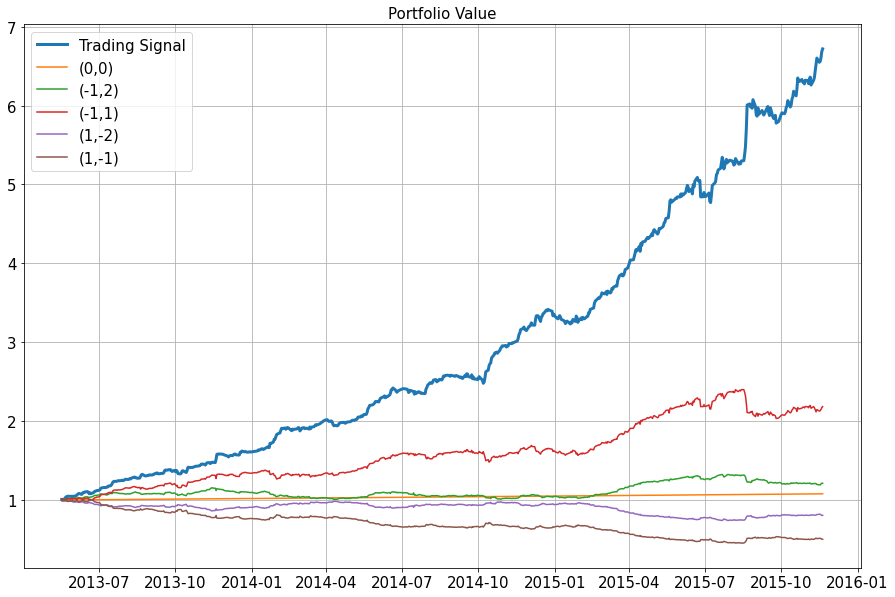



K-Folds Cross Validation:  4
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2015-12-01 00:00:00  to  2018-06-15 00:00:00
Testing Fold Size:  640


Epoch 74: early stopping
Cumulative Return (percentage annualized) : 342.5148
Sharpe ratio (percentage) : 4.7687


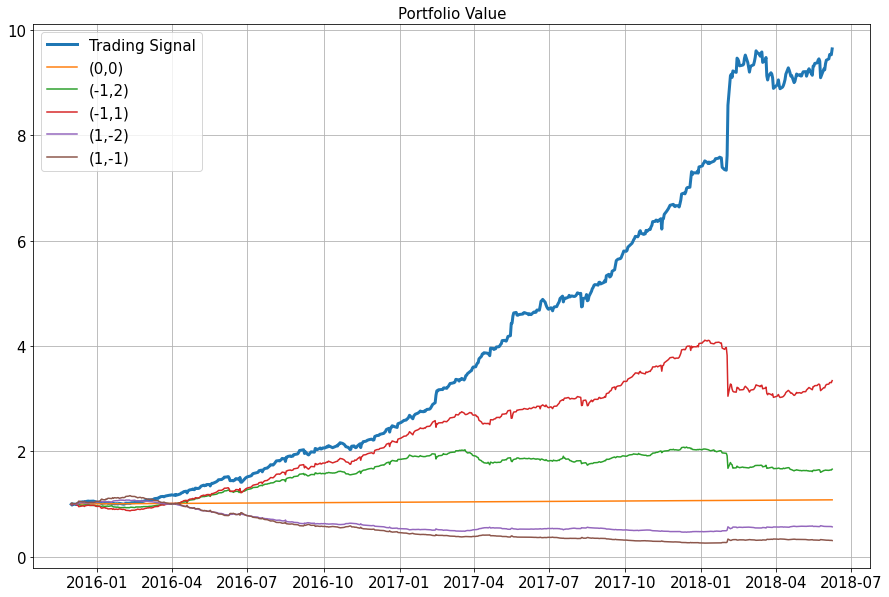



K-Folds Cross Validation:  5
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2018-06-15 00:00:00
Testing Dates:  2018-06-18 00:00:00  to  2020-12-30 00:00:00
Testing Fold Size:  640


Epoch 61: early stopping
Cumulative Return (percentage annualized) : 553.0596
Sharpe ratio (percentage) : 6.5580


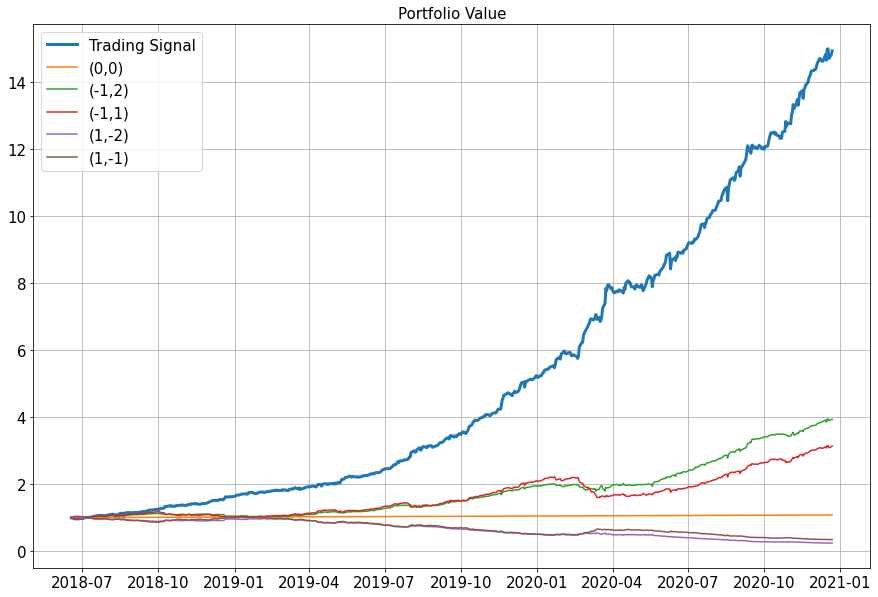

In [7]:
'''
K-fold with a lookback window = 5
'''
look_back = 5
fold_number = 5
k_folds = KFold(n_splits = fold_number) 
k = int(0)

for train_index, test_index in k_folds.split(X[:,0:-1].T): # 針對每一次不同的Fold
    print( '\n' )
    print( 'K-Folds Cross Validation: ', k+1 )
    print( 'Total Data Size: ', X.shape[1]-1 )
    print( 'Training Fold Size: ', train_index.shape[ 0 ] )
    print( 'Training Dates: ', dates.iloc[ train_index[ 0 ] ], ' to ', dates.iloc[ train_index[ -1 ] ] )
    print( 'Testing Dates: ', dates.iloc[ test_index[ 0 ] ], ' to ', dates.iloc[ test_index[ -1 ] ] )
    print( 'Testing Fold Size: ', test_index.shape[ 0 ] )
    print( '\n' )

    ### Create dataset
    old_train_X=X.T[train_index,:]
    old_train_y=ind_trade[train_index,:]
    old_test_X=X.T[test_index,:]
    old_test_y=ind_trade[test_index,:]
    New_train_X, New_train_y = create_dataset(old_train_X,old_train_y,look_back=look_back)
    New_test_X, New_test_y = create_dataset(old_test_X,old_test_y,look_back=look_back)

    ### NN model
    relu_parameter = 0.1
    neuron_num = 1000
    activation_function = lambda x: tf.keras.activations.relu( x, relu_parameter ) # Parameteric rectified linear unit

    model = tf.keras.Sequential( )
    model.add( tf.keras.layers.Flatten( input_shape = (look_back,11) ) ) # 這邊要注意 look back
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( 5, activation = 'softmax'  ) )

    model.compile( loss = 'categorical_crossentropy', optimizer = 'adam',\
                  metrics = [ 'accuracy', 'mse' ] )

    # 設定Earlystop 避免overfitting
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.005,\
                                              mode='max', verbose=1,patience = 50)

    model_history = model.fit(New_train_X, New_train_y, \
                      epochs = 20000, batch_size = New_train_X.shape[0], shuffle = True,\
                              validation_split = .3,verbose = False, callbacks=[es])

    #################### 以下還沒改
    
    ### Out-of-sample test
    y_score = model.predict(New_test_X)
    my_predict = np.argmax(y_score,axis = 1)

    r_my_trade=r_trade[test_index[:-look_back],my_predict] # 最新的資料因為lookback被剃除了
    p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
    p_trade = np.exp(np.cumsum(np.log(1+r_trade[test_index[:-look_back],:]),axis=0))

    ### Print return / sharpe ratio
    my_mu = np.mean(np.diff(p_my_trade)/p_my_trade[0:-1])/dt
    my_vol = np.std(np.diff(p_my_trade)/p_my_trade[0:-1])/np.sqrt(dt)
    profit = (100*(p_my_trade[-1]-p_my_trade[0])/p_my_trade[0])/(len(test_index)*dt) # 年化 return
    SR = my_mu/my_vol
    print("Cumulative Return (percentage annualized) : %.4f" %profit)
    print("Sharpe ratio (percentage) : %.4f"%SR)

    ### Show the figure
    plt.figure(figsize=(15,10))
    plt.plot(dates[test_index[:-look_back]],p_my_trade,
             label="Trading Signal",linewidth=3);
    labels = ["(0,0)","(-1,2)","(-1,1)","(1,-2)","(1,-1)"]
    for i in range(5):
        plt.plot(dates[test_index[:-look_back]],p_trade[:,i], label=labels[i]);

    plt.title('Portfolio Value', fontsize = 15 )
    plt.xticks( fontsize = 15 );
    plt.yticks( fontsize = 15 )
    plt.legend(loc="upper left",fontsize = 15)
    plt.grid( which = 'major' )
    plt.grid( which = 'minor', linestyle = ':' )
    plt.show()
    k = k+1



K-Folds Cross Validation:  1
Total Data Size:  3201
Training Fold Size:  2560
Training Dates:  2010-10-29 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2008-04-16 00:00:00  to  2010-10-28 00:00:00
Testing Fold Size:  641


Epoch 51: early stopping
Cumulative Return (percentage annualized) : 225.6096
Sharpe ratio (percentage) : 5.0955


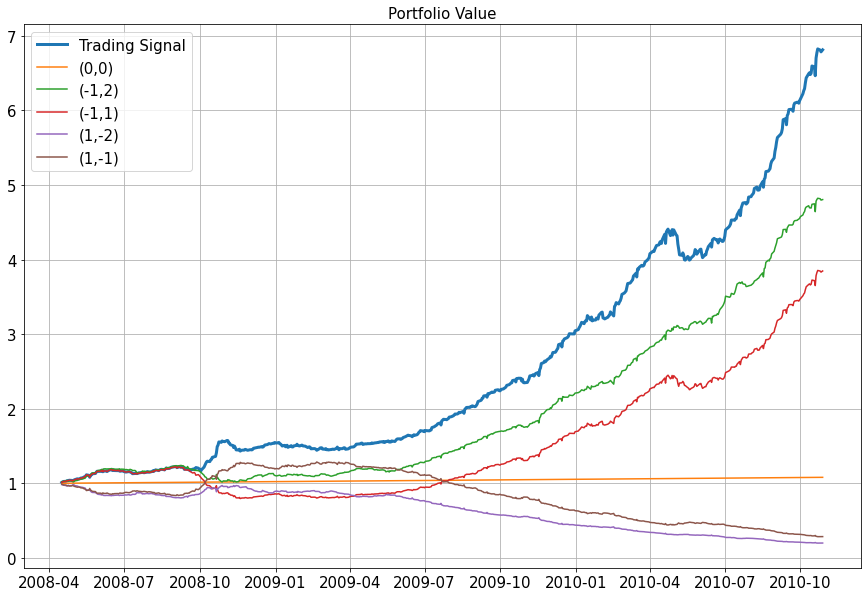



K-Folds Cross Validation:  2
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2010-10-29 00:00:00  to  2013-05-16 00:00:00
Testing Fold Size:  640


Epoch 71: early stopping
Cumulative Return (percentage annualized) : 206.3603
Sharpe ratio (percentage) : 3.9699


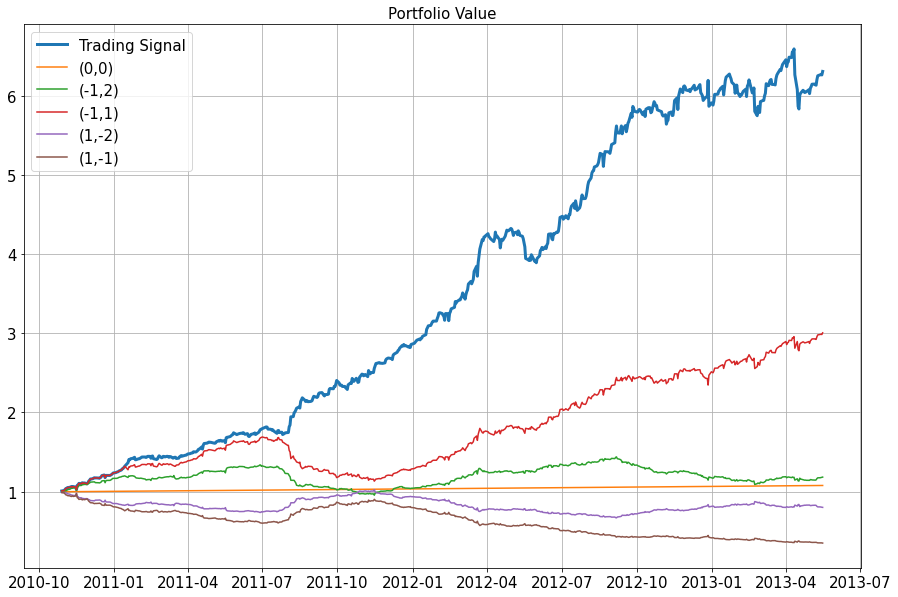



K-Folds Cross Validation:  3
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2013-05-17 00:00:00  to  2015-11-30 00:00:00
Testing Fold Size:  640


Epoch 64: early stopping
Cumulative Return (percentage annualized) : 35.8789
Sharpe ratio (percentage) : 1.7663


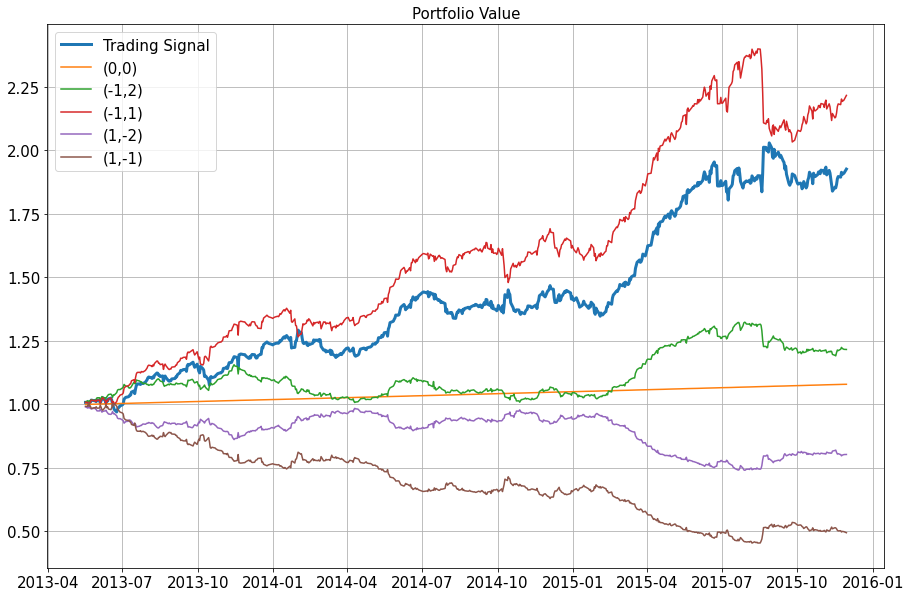



K-Folds Cross Validation:  4
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2020-12-30 00:00:00
Testing Dates:  2015-12-01 00:00:00  to  2018-06-15 00:00:00
Testing Fold Size:  640


Epoch 68: early stopping
Cumulative Return (percentage annualized) : 173.6165
Sharpe ratio (percentage) : 3.1411


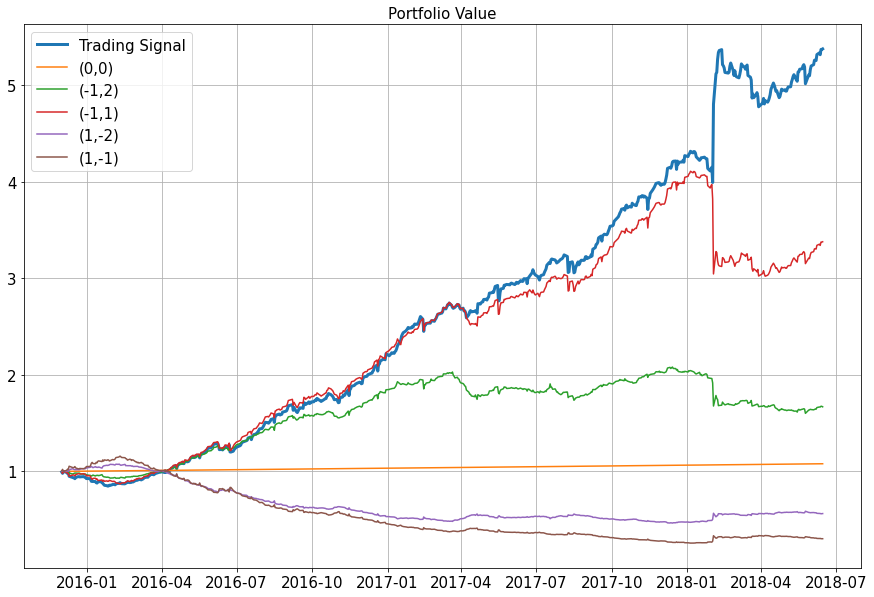



K-Folds Cross Validation:  5
Total Data Size:  3201
Training Fold Size:  2561
Training Dates:  2008-04-16 00:00:00  to  2018-06-15 00:00:00
Testing Dates:  2018-06-18 00:00:00  to  2020-12-30 00:00:00
Testing Fold Size:  640


Epoch 70: early stopping
Cumulative Return (percentage annualized) : 97.3928
Sharpe ratio (percentage) : 2.8982


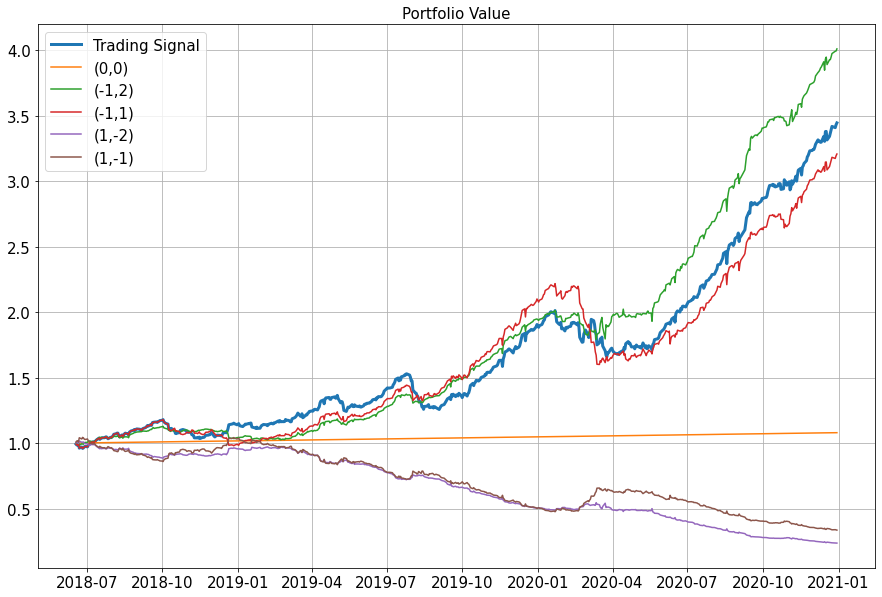

In [8]:
'''
K-fold without lookback
'''
fold_number = 5
k_folds = KFold(n_splits = fold_number) 
k = int(0)

for train_index, test_index in k_folds.split(X[:,0:-1].T): # 針對每一次不同的Fold
    print( '\n' )
    print( 'K-Folds Cross Validation: ', k+1 )
    print( 'Total Data Size: ', X.shape[1]-1 )
    print( 'Training Fold Size: ', train_index.shape[ 0 ] )
    print( 'Training Dates: ', dates.iloc[ train_index[ 0 ] ], ' to ', dates.iloc[ train_index[ -1 ] ] )
    print( 'Testing Dates: ', dates.iloc[ test_index[ 0 ] ], ' to ', dates.iloc[ test_index[ -1 ] ] )
    print( 'Testing Fold Size: ', test_index.shape[ 0 ] )
    print( '\n' )

    ### Create dataset
    New_train_X=X.T[train_index,:]
    New_train_y=ind_trade[train_index,:]
    New_test_X=X.T[test_index,:]
    New_test_y=ind_trade[test_index,:]

    ### NN model
    relu_parameter = 0.1
    neuron_num = 1000
    activation_function = lambda x: tf.keras.activations.relu( x, relu_parameter ) # Parameteric rectified linear unit

    model = tf.keras.Sequential( )
    model.add( tf.keras.layers.Flatten( input_shape = ( 11, ) ) ) # 這邊要注意 look back
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
    model.add( tf.keras.layers.Dense( 5, activation = 'softmax'  ) )

    model.compile( loss = 'categorical_crossentropy', optimizer = 'adam',\
                  metrics = [ 'accuracy', 'mse' ] )

    # 設定Earlystop 避免overfitting
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.005,\
                                              mode='max', verbose=1,patience = 50)

    model_history = model.fit(New_train_X, New_train_y, \
                      epochs = 20000, batch_size = New_train_X.shape[0], shuffle = True,\
                              validation_split = .3,verbose = False, callbacks=[es])

    ### Out-of-sample test
    y_score = model.predict(New_test_X)
    my_predict = np.argmax(y_score,axis = 1)

    r_my_trade=r_trade[test_index,my_predict] # 最新的資料因為lookback被剃除了
    p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
    p_trade = np.exp(np.cumsum(np.log(1+r_trade[test_index,:]),axis=0))

    ### Print return / sharpe ratio
    my_mu = np.mean(np.diff(p_my_trade)/p_my_trade[0:-1])/dt
    my_vol = np.std(np.diff(p_my_trade)/p_my_trade[0:-1])/np.sqrt(dt)
    profit = (100*(p_my_trade[-1]-p_my_trade[0])/p_my_trade[0])/(len(test_index)*dt) # 年化 return
    SR = my_mu/my_vol
    print("Cumulative Return (percentage annualized) : %.4f" %profit)
    print("Sharpe ratio (percentage) : %.4f"%SR)

    ### Show the figure
    plt.figure(figsize = ( 15, 10 ))
    plt.plot(dates[test_index],p_my_trade,
             label="Trading Signal",linewidth=3);
    labels = ["(0,0)","(-1,2)","(-1,1)","(1,-2)","(1,-1)"]
    for i in range(5):
        plt.plot(dates[test_index],p_trade[:,i], label=labels[i]);

    plt.title('Portfolio Value', fontsize = 15 )
    plt.xticks( fontsize = 15 );
    plt.yticks( fontsize = 15 )
    plt.legend(loc="upper left",fontsize = 15)
    plt.grid( which = 'major' )
    plt.grid( which = 'minor', linestyle = ':' )
    plt.show()
    k = k+1